Primero: cargar los datos.

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
BD_Obesity = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = BD_Obesity.data.features 
y = BD_Obesity.data.targets 

In [2]:
import pandas as pd

Segundo: revisión de datos

In [3]:
import pandas as pd

BD_Obesity = pd.DataFrame(X)
BD_Obesity_y = pd.DataFrame(y)

BD_Obesity['Target'] = BD_Obesity_y

BD_Obesity.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [4]:
BD_Obesity_y.describe()

,NObeyesdad
count,2111
unique,7
top,Obesity_Type_I
freq,351


Segundo: preprocesamiento de datos

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


if BD_Obesity is not None:
    # Identificar variables categóricas y numéricas
    categorical_cols = BD_Obesity.select_dtypes(include=['object', 'category']).columns
    numerical_cols = BD_Obesity.select_dtypes(include=['number']).columns

    # Imputación de variables categóricas y numéricas
    imputer_categoricas = SimpleImputer(strategy='most_frequent')
    imputer_numericas = SimpleImputer(strategy='mean')

    BD_Obesity[categorical_cols] = imputer_categoricas.fit_transform(BD_Obesity[categorical_cols])
    BD_Obesity[numerical_cols] = imputer_numericas.fit_transform(BD_Obesity[numerical_cols])

    # Codificación de variables categóricas
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    BD_Obesity_ohe = ohe.fit_transform(BD_Obesity[categorical_cols])

    # Convertir la codificación One-Hot en DataFrame y unirlo con las variables numéricas
    BD_Obesity_ohe_df = pd.DataFrame(BD_Obesity_ohe, columns=ohe.get_feature_names_out(categorical_cols))
    BD_Obesity_Encoded = pd.concat([BD_Obesity[numerical_cols].reset_index(drop=True), BD_Obesity_ohe_df], axis=1)
else:
    print("El DataFrame BD_Obesity es None. Verifica la carga de datos.")



Tercero: escalar los datos y luego aplica PCA para la reducción dimensional.

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



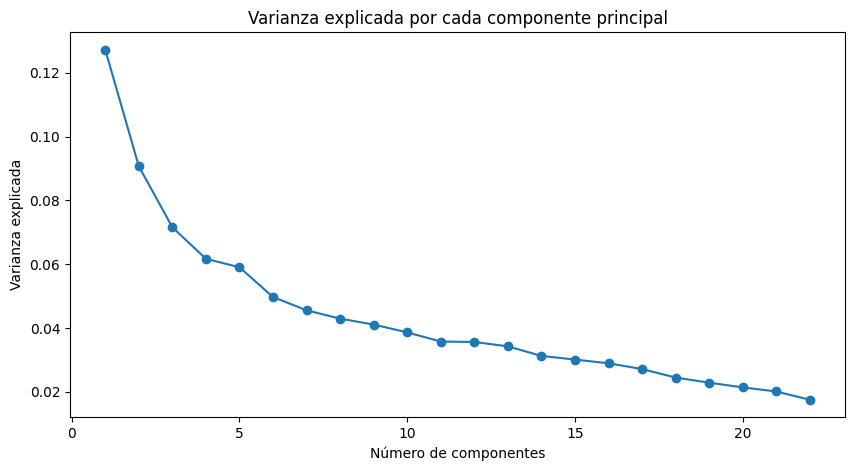

In [8]:

if BD_Obesity is not None:
    # Escalar los datos antes de aplicar PCA
    scaler = StandardScaler()
    BD_Obesity_Scaled = scaler.fit_transform(BD_Obesity_Encoded)

    # Aplicar PCA para la reducción dimensional
    pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
    X_pca = pca.fit_transform(BD_Obesity_Scaled)

    # Visualizar la varianza explicada por cada componente principal
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
    plt.title('Varianza explicada por cada componente principal')
    plt.xlabel('Número de componentes')
    plt.ylabel('Varianza explicada')
    plt.show()
else:
    print("El DataFrame BD_Obesity es None. Verifica la carga de datos.")


Cuarto: usar los componentes principales obtenidos para entrenar un modelo XGBoost.

In [9]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder



In [10]:
if BD_Obesity is not None:
    # Codificar la variable objetivo
    y = BD_Obesity['Target']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # División de los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

    # Crear y entrenar el modelo XGBoost
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
else:
    print("El DataFrame BD_Obesity es None. Verifica la carga de datos.")


Accuracy: 0.9692671394799054
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        56
           1       0.95      0.95      0.95        62
           2       1.00      0.97      0.99        78
           3       1.00      0.98      0.99        58
           4       1.00      1.00      1.00        63
           5       0.91      0.95      0.93        56
           6       0.96      1.00      0.98        50

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.97      0.97      0.97       423



Quinto: Interpretación de resultado --> el anterior módelo muestran un alto rendimiento con una precisión del 96.93%. El informe de clasificación también muestra altos valores de precisión, recall y f1-score para todas las clases, lo que indica que el modelo está funcionando bien para todas las categorías.

Sexto: hacer visualización de la matriz de confusión.

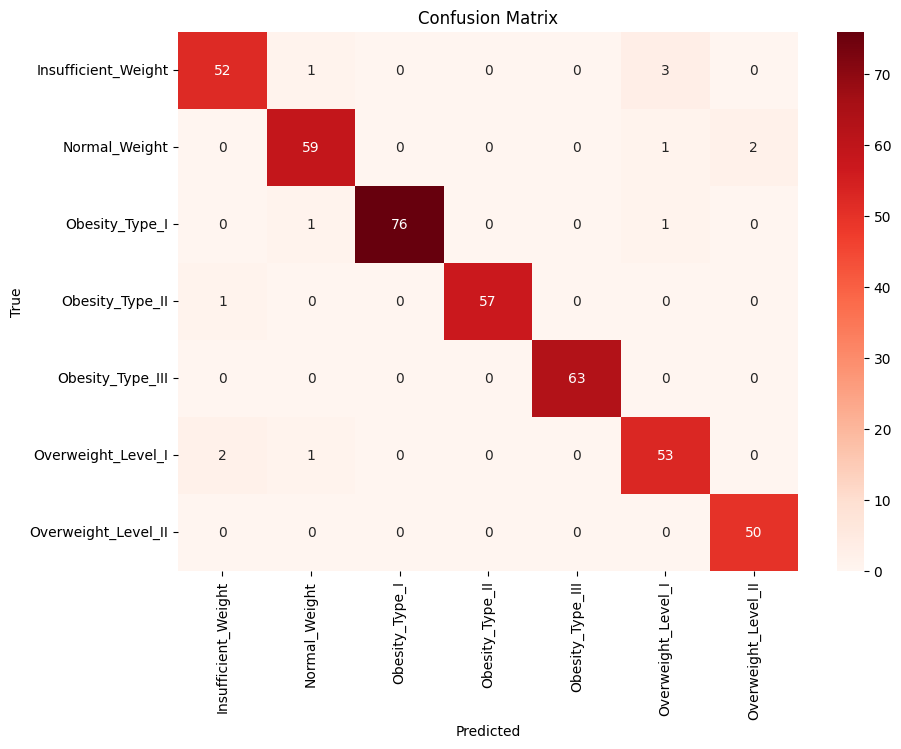

In [11]:
# Visualización de la Matriz de Confusión
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Séptimo: interpretación -->

Octavo: comprensión sobre la reducción dimensional con PCA y la afectación en los datos.

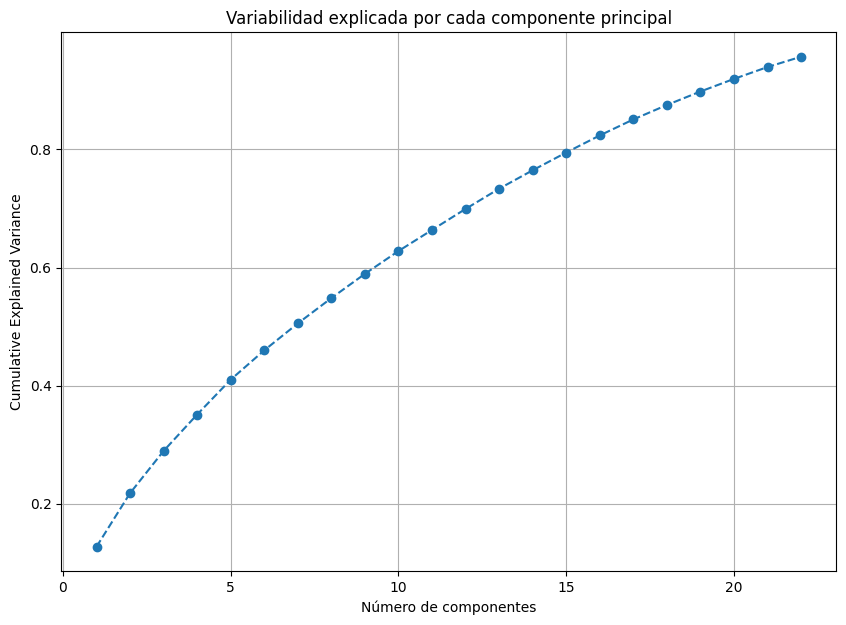

In [12]:
# Visualizar la variabilidad explicada por cada componente principal
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variabilidad explicada por cada componente principal')
plt.grid()
plt.show()
